# Shift

Do imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ae483tools import *

Load data from a flight in which the drone took off, moved in a square, and landed.

In [2]:
raw_data_drone, raw_data_mocap = load_hardware_data('square.json')

Resample drone data.

In [3]:
data_drone = resample_data_drone(raw_data_drone, t_min_offset=0.019, t_max_offset=0.)

t = data_drone['time']
x_drone = data_drone['stateEstimate.x']
y_drone = data_drone['stateEstimate.y']
z_drone = data_drone['stateEstimate.z']
psi_drone = np.deg2rad(data_drone['stateEstimate.yaw'])
theta_drone = - np.deg2rad(data_drone['stateEstimate.pitch'])
phi_drone = np.deg2rad(data_drone['stateEstimate.roll'])

Resample mocap data **with a non-zero time shift** and apply coordinate transformation.

In [4]:
resampled_data_mocap = resample_data_mocap(raw_data_mocap, t, t_shift=-1.)
transformed_data_mocap = transform_data_mocap(resampled_data_mocap)

# Only get z estimate from mocap for now
z_mocap = transformed_data_mocap['z']

Plot data.

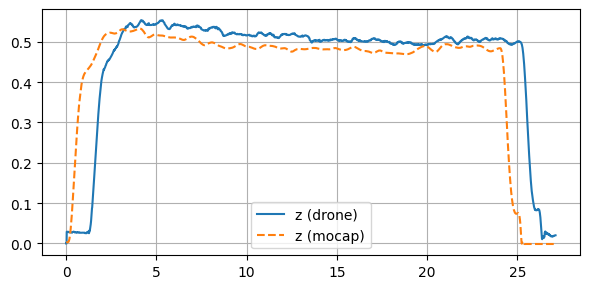

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), tight_layout=True)
ax.plot(t, z_drone, label='z (drone)')
ax.plot(t, z_mocap, '--', label='z (mocap)')
ax.legend()
ax.grid()

Find the root-mean-square-error (RMSE) for a range of time shifts.

In [6]:
# Create an array with a range of time shifts
t_shifts = np.linspace(0., 0.2, 21)

# Create an array to hold the RMSE for each time shift
RMSEs = np.empty_like(t_shifts)

# Find the RMSE for each time shift
for i, t_shift in enumerate(t_shifts):
    # Resample mocap data with time shift
    resampled_data_mocap = resample_data_mocap(raw_data_mocap, t, t_shift=t_shift)

    # Transform mocap data
    transformed_data_mocap = transform_data_mocap(resampled_data_mocap)

    # Get z estimate from mocap data
    z_mocap = transformed_data_mocap['z']

    # Find RMSE between z_mocap and z_drone
    RMSEs[i] = np.sqrt(np.mean((z_mocap - z_drone)**2))

Plot the RMSE for a range of time shifts.

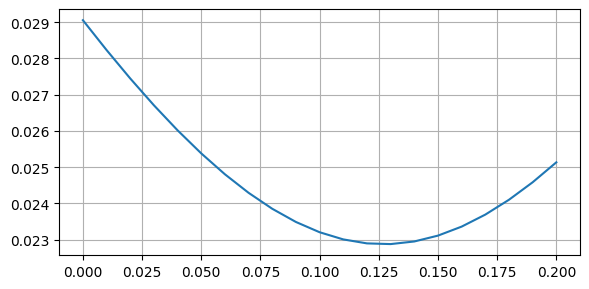

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), tight_layout=True)
ax.plot(t_shifts, RMSEs)
ax.grid()

Find the time shift that gives the minimum RMSE.

In [8]:
# Find the index of the minimum RMSE
i_min = np.argmin(RMSEs)       # <-- FIXME

# Find the minimum RMSE
RMSE_min = RMSEs[i_min]       # <-- FIXME

# Find the time shift that gives the minimum RMSE
t_shift_min = t_shifts[i_min]    # <-- FIXME
print(t_shift_min)

0.13


Plot the RMSE for a range of time shifts again, this time showing the minimum.

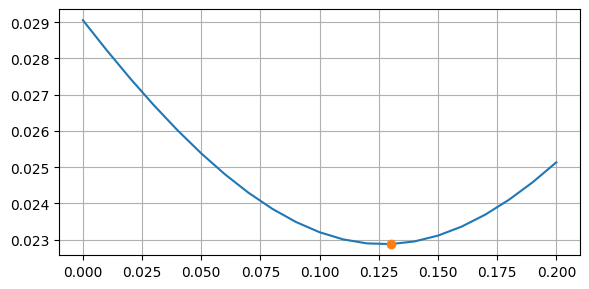

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), tight_layout=True)
ax.plot(t_shifts, RMSEs)
ax.plot(t_shift_min, RMSE_min, '.', markersize=12)
ax.grid()

Define a function to synchronize mocap data with drone data (i.e., to find the time shift that best aligns transformed mocap data with drone data).

In [10]:
def sync_data_mocap(raw_data_mocap, t, z_drone):

    def get_RMSE(raw_data_mocap, t, t_shift, z_drone):
        resampled_data_mocap = resample_data_mocap(raw_data_mocap, t, t_shift=t_shift)
        transformed_data_mocap = transform_data_mocap(resampled_data_mocap)
        z_mocap = transformed_data_mocap['z']
        return np.sqrt(np.mean((z_mocap - z_drone)**2))
    
    dt = 0.01 # timestep to increment by
    # init data
    RMSE_zero = get_RMSE(raw_data_mocap, t, 0.0, z_drone)
    RMSE_pos = get_RMSE(raw_data_mocap, t, dt, z_drone)
    RMSE_neg = get_RMSE(raw_data_mocap, t, -dt, z_drone)
    if (RMSE_zero < RMSE_pos) and (RMSE_zero < RMSE_neg):
        t_shift_min=0.
        loop = False
    elif RMSE_neg > RMSE_pos:
        # search forward in time
        RMSE_min = RMSE_pos
        t_shift_min = dt
        loop = True
        inc = dt
    else:
        # search backward in time
        RMSE_min = RMSE_neg
        t_shift_min = -dt
        loop = True
        inc = -dt
    
    while loop:
        RMSE_new = get_RMSE(raw_data_mocap, t, t_shift_min+inc, z_drone)
        if RMSE_new < RMSE_min:
            RMSE_min = RMSE_new
            t_shift_min += inc
        else:
            break
    
    # Resample mocap data with the time shift that minimizes RMSE
    resampled_data_mocap = resample_data_mocap(raw_data_mocap, t, t_shift=t_shift_min)

    # Transform mocap data
    transformed_data_mocap = transform_data_mocap(resampled_data_mocap)

    # Return the result
    return transformed_data_mocap

Apply synchronization to mocap data.

In [11]:
data_mocap = sync_data_mocap(raw_data_mocap, t, z_drone)

x_mocap = data_mocap['x']
y_mocap = data_mocap['y']
z_mocap = data_mocap['z']
psi_mocap = data_mocap['yaw']
theta_mocap = data_mocap['pitch']
phi_mocap = data_mocap['roll']

Plot all data.

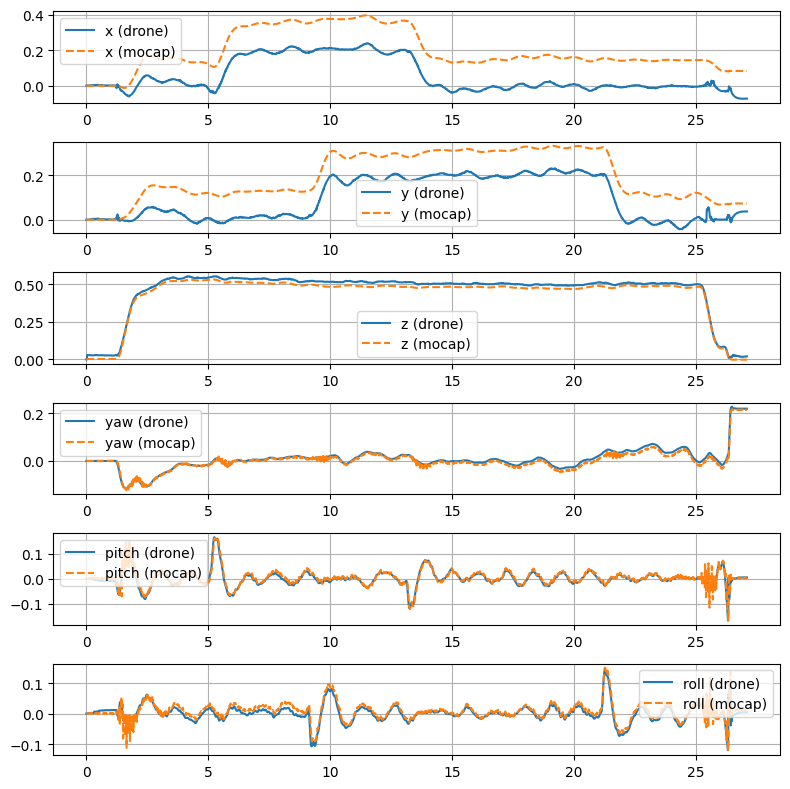

In [12]:
fig, (ax_x, ax_y, ax_z, ax_psi, ax_theta, ax_phi) = plt.subplots(6, 1, figsize=(8, 8), tight_layout=True)

ax_x.plot(t, x_drone, label='x (drone)')
ax_x.plot(t, x_mocap, '--', label='x (mocap)')
ax_x.legend()
ax_x.grid()

ax_y.plot(t, y_drone, label='y (drone)')
ax_y.plot(t, y_mocap, '--', label='y (mocap)')
ax_y.legend()
ax_y.grid()

ax_z.plot(t, z_drone, label='z (drone)')
ax_z.plot(t, z_mocap, '--', label='z (mocap)')
ax_z.legend()
ax_z.grid()

ax_psi.plot(t, psi_drone, label='yaw (drone)')
ax_psi.plot(t, psi_mocap, '--', label='yaw (mocap)')
ax_psi.legend()
ax_psi.grid()

ax_theta.plot(t, theta_drone, label='pitch (drone)')
ax_theta.plot(t, theta_mocap, '--', label='pitch (mocap)')
ax_theta.legend()
ax_theta.grid()

ax_phi.plot(t, phi_drone, label='roll (drone)')
ax_phi.plot(t, phi_mocap, '--', label='roll (mocap)')
ax_phi.legend()
ax_phi.grid()